In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

In [2]:
infile = '/g/data/r87/dbi599/temp/thetao_Omon_IPSL-CM5A-LR_historical_r1i1p1_1850-01-01.nc'
#infile = '/g/data/ua6/DRSv3/CMIP5/IPSL-CM5A-LR/historical/mon/ocean/r1i1p1/thetao/latest/thetao_Omon_IPSL-CM5A-LR_historical_r1i1p1_185001-189912.nc'

In [3]:
ds = xr.open_dataset(infile, decode_times=False)
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, i: 182, j: 149, lev: 31, time: 1, vertices: 4)
Coordinates:
  * time       (time) float64 15.5
    lon        (j, i) float32 ...
    lat        (j, i) float32 ...
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 175 176 177 178 179 180 181 182
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 142 143 144 145 146 147 148 149
  * lev        (lev) float64 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds  (time, bnds) float64 ...
    lon_bnds   (j, i, vertices) float32 ...
    lat_bnds   (j, i, vertices) float32 ...
    lev_bnds   (lev, bnds) float64 ...
    thetao     (time, lev, j, i) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.9.2 (http://mpim...
    Conventions:            CF-1.4
    history:                Thu Mar 28 13:15:50 2019: cdo seldate,1850-01-01,...
    source:                 IPSL-CM5A-LR (2010) : atmos : LMDZ4 (LMDZ4_v5

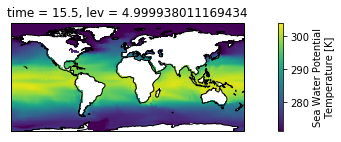

In [4]:
plt.figure(figsize=(12,2));
ax = plt.axes(projection=ccrs.PlateCarree());
ds['thetao'][0, 0, ::].plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();

In [10]:
ds_out = xe.util.grid_global(5, 4)

#ds_out = xr.Dataset({'lat': (['lat'], np.arange(-80, 81, 1)),
#                     'lon': (['lon'], np.arange(2, 362, 2)),
#                    }
#                   )

In [6]:
regridder = xe.Regridder(ds, ds_out, 'bilinear') 

Create weight file: bilinear_149x182_45x72.nc


ValueError: ESMC_FieldRegridStoreFile() failed with rc = 506.    Please check the log files (named "*ESMF_LogFile").

The regular approach to remapping fails...

# Check grid structure

In [5]:
ds['lon']

<xarray.DataArray 'lon' (j: 149, i: 182)>
array([[78.00004, 80.     , 81.99996, ..., 76.00008, 78.00004, 80.     ],
       [78.00004, 80.     , 81.99996, ..., 76.00008, 78.00004, 80.     ],
       [78.00004, 80.     , 81.99996, ..., 76.00008, 78.00004, 80.     ],
       ...,
       [79.77896, 80.     , 80.22104, ..., 79.66438, 79.77896, 80.     ],
       [80.     , 80.     , 80.     , ..., 80.     , 80.     , 80.     ],
       [80.22104, 80.     , 79.77896, ..., 80.33562, 80.22104, 80.     ]],
      dtype=float32)
Coordinates:
    lon      (j, i) float32 78.00004 80.0 81.99996 ... 80.33562 80.22104 80.0
    lat      (j, i) float32 ...
  * i        (i) int32 1 2 3 4 5 6 7 8 9 ... 174 175 176 177 178 179 180 181 182
  * j        (j) int32 1 2 3 4 5 6 7 8 9 ... 141 142 143 144 145 146 147 148 149
Attributes:
    standard_name:        longitude
    long_name:            longitude coordinate
    units:                degrees_east
    _CoordinateAxisType:  Lon
    bounds:               lon_b

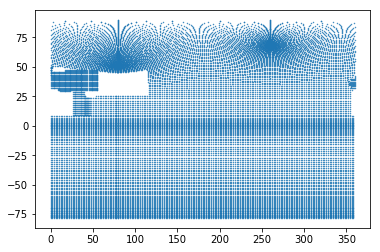

In [6]:
# multiple titles are stacked into a single 2D array
# just passinsg this will crash ESMPy 
plt.scatter(ds['lon'], ds['lat'], s=0.2)

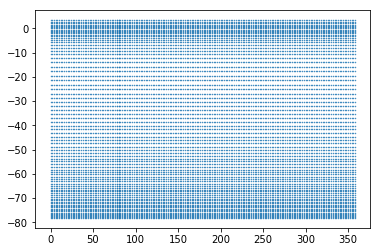

In [7]:
# Get a more well-defined 2D mesh (subset of the full grid)
plt.scatter(ds['lon'][:80,:], ds['lat'][:80,], s=0.2)

# Correctly build the regridder

In [8]:
ds_subset = ds.isel(i=slice(0,80), j=slice(0,80))

In [11]:
regridder = xe.Regridder(ds_subset, ds_out, 'bilinear') 

Create weight file: bilinear_80x80_45x72.nc


/g/data/r87/dbi599/miniconda3/envs/remapping/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


In [13]:
dr_out = regridder(ds['thetao'][:, :, 0:80, 0:80])

/g/data/r87/dbi599/miniconda3/envs/remapping/lib/python3.7/site-packages/xesmf/smm.py:73: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


In [16]:
dr_out

<xarray.DataArray 'thetao' (time: 1, lev: 31, y: 45, x: 72)>
array([[[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]]])
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 ... 88.0 88.0 88.0 88.0
  * time     (time) float64 15.5
  * lev      (lev) float64 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

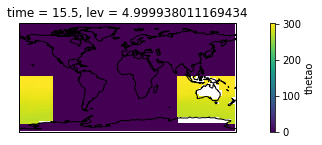

In [17]:
plt.figure(figsize=(12,2));
ax = plt.axes(projection=ccrs.PlateCarree());
dr_out[0, 0, ::].plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();

So the error could be fixed by breaking your full grid to several well-defined 2D tiles... or maybe it's easier to just use CDO...

# CDO remapbil instead...

In [19]:
cdo_infile = '/g/data/r87/dbi599/temp/thetao_Omon_IPSL-CM5A-LR_historical_r1i1p1_1850-01-01_susan-grid-cdo.nc'

In [20]:
ds_cdo = xr.open_dataset(cdo_infile, decode_times=False)
ds_cdo

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 161, lev: 31, lon: 180, time: 1)
Coordinates:
  * time       (time) float64 15.5
  * lon        (lon) float64 2.0 4.0 6.0 8.0 10.0 ... 354.0 356.0 358.0 360.0
  * lat        (lat) float64 -80.0 -79.0 -78.0 -77.0 ... 77.0 78.0 79.0 80.0
  * lev        (lev) float64 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lev_bnds   (lev, bnds) float64 ...
    thetao     (time, lev, lat, lon) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.9.2 (http://mpim...
    Conventions:            CF-1.4
    history:                Fri Mar 29 10:02:03 2019: cdo remapbil,/g/data/r8...
    source:                 IPSL-CM5A-LR (2010) : atmos : LMDZ4 (LMDZ4_v5, 96...
    institution:            IPSL (Institut Pierre Simon Laplace, Paris, France)
    inst

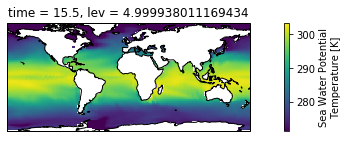

In [21]:
plt.figure(figsize=(12,2));
ax = plt.axes(projection=ccrs.PlateCarree());
ds_cdo['thetao'][0, 0, ::].plot.pcolormesh(ax=ax);
ax.coastlines();

In [29]:
ds_cdo['lev'].data[0]

4.999938011169434

In [35]:
test_file = '/g/data/r87/dbi599/DRSv2/CMIP5/IPSL-CM5A-LR/historical/mon/ocean/r1i1p1/thetao/latest/thetao_Omon_IPSL-CM5A-LR_historical_r1i1p1_185001-189912_susan-horiz-grid.nc'

In [36]:
ds_test = xr.open_dataset(test_file, decode_times=False)
ds_test

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 161, lev: 31, lon: 180, time: 600)
Coordinates:
  * time       (time) float64 15.5 45.0 74.5 ... 1.817e+04 1.82e+04 1.823e+04
  * lon        (lon) float64 2.0 4.0 6.0 8.0 10.0 ... 354.0 356.0 358.0 360.0
  * lat        (lat) float64 -80.0 -79.0 -78.0 -77.0 ... 77.0 78.0 79.0 80.0
  * lev        (lev) float64 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lev_bnds   (lev, bnds) float64 ...
    thetao     (time, lev, lat, lon) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.9.2 (http://mpim...
    Conventions:            CF-1.4
    history:                Fri Mar 29 11:31:42 2019: cdo remapbil,/g/data/r8...
    source:                 IPSL-CM5A-LR (2010) : atmos : LMDZ4 (LMDZ4_v5, 96...
    institution:            IPSL (Institut 

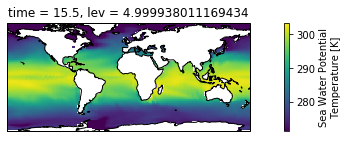

In [37]:
plt.figure(figsize=(12,2));
ax = plt.axes(projection=ccrs.PlateCarree());
ds_test['thetao'][0, 0, ::].plot.pcolormesh(ax=ax);
ax.coastlines();

In [38]:
type(ds_test['thetao'].data)

numpy.ndarray

In [39]:
ds_test['thetao'].

AttributeError: 'DataArray' object has no attribute 'attributes'